# Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re
from datetime import datetime

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Setup
sns.set_style("whitegrid")
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 1. Data Loading & Cleaning
We load the cleaned **Advertising (User)** dataset.
* **Target:** `conversion_rate`
* **Action:** We remove any non-numeric columns and ensure missing values are handled.

In [ ]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../Cleaned_Datasets/Advertising/advertising_v6_full_time_features.csv")
print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])

# DROP COLUMNS THAT CAUSE LEAKAGE
df = df.drop(columns=['Unnamed: 0', 'Unnamed__0','cost_per_click', 'click_through_rate', 'view_time','ROI'], errors='ignore')

# DEFINE TARGET
TARGET = 'conversion_rate'

# Basic Encoding (if any object columns remain)
df = pd.get_dummies(df, drop_first=True)
df = df.fillna(0)

print(f"Final Data Shape: {df.shape}")

Loading file: ../Cleaned_Datasets/Advertising/advertising_v6_full_time_features.csv
Final Data Shape: (1000, 34)


## 2. Feature Selection
To improve model performance and reduce noise, we "play" with features using:
1.  **Correlation Matrix:** Visualizing linear relationships.
2.  **SelectKBest:** Statistical test to pick the top 10 most influential features.

In [ ]:
# 1. DEFINE X and Y
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# 2. SANITIZE COLUMN NAMES
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
print("✅ Column names sanitized.")

# 3. SELECT TOP 10 FEATURES
print("Selecting TOP 10 features.")
selector = SelectKBest(score_func=f_regression, k=10) 
selector.fit(X, y)

# Get the names of the selected columns
cols = selector.get_support(indices=True)
X_selected = X.iloc[:, cols]

# OVERWRITE X with the reduced version
X = X_selected

print(f"✅ Features ready: {X.shape[1]}")
print(f"   Selected: {X.columns.tolist()}")

✅ Column names sanitized.
Selecting TOP 10 features for Experiment 4...
✅ Features ready: 10
   Selected: ['age_group_encoded', 'engagement_level_encoded', 'device_type_Tablet', 'location_Germany', 'location_India', 'content_type_Text', 'content_type_Video', 'ad_topic_Finance', 'ad_target_audience_Professionals', 'ad_target_audience_Students']


## 3. Baseline Model Comparison
We train three "classical" models with default parameters to establish a baseline.
* Random Forest
* XGBoost
* LightGBM

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(random_state=42), 
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'RMSE':<10} | {'Gap (Train-Test)'}")
print("-" * 80)

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train) 
    
    # Calculate Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Gap > 0.10 usually means Overfitting
    gap = r2_train - r2_test
    
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {rmse:.4f}     | {gap:.4f}")

print("-" * 80)

Model           | Test R2    | Train R2   | RMSE       | Gap (Train-Test)
--------------------------------------------------------------------------------
RandomForest    | 0.7418     | 0.8497     | 0.0104     | 0.1080
XGBoost         | 0.7480     | 0.8201     | 0.0103     | 0.0721
LightGBM        | 0.7682     | 0.7848     | 0.0099     | 0.0166
--------------------------------------------------------------------------------


## 4. Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define Parameter Grids
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50]
    }
}

print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'CV Score':<10}")
print("-" * 80)

# Variables to track the "Best of the Best" for saving
best_opt_r2 = -float('inf')
best_opt_model = None
best_model_name = None 

# 2. LOOP THROUGH ALL MODELS
for name, model in models.items():
    if name in param_grids:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=5,
            cv=3, 
            scoring='r2', 
            n_jobs=-1, 
            random_state=42
        )
        
        search.fit(X_train, y_train)
        
        # Get Best Optimized Model
        opt_model = search.best_estimator_
        
        # Predict
        y_pred_test = opt_model.predict(X_test)
        y_pred_train = opt_model.predict(X_train)
        
        # Metrics
        r2_test = r2_score(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        gap = r2_train - r2_test
        cv_score = search.best_score_
        
        print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | {cv_score:.4f}")
        
        # Track the ultimate winner
        if r2_test > best_opt_r2:
            best_opt_r2 = r2_test
            best_opt_model = opt_model
            best_model_name = name

print("-" * 80)
print(f"Ultimate Winner: {best_model_name} (R2: {best_opt_r2:.4f})")
opt_r2 = best_opt_r2

Model           | Test R2    | Train R2   | Gap        | CV Score  
--------------------------------------------------------------------------------
RandomForest    | 0.7646     | 0.7923     | 0.0277     | 0.6653
XGBoost         | 0.7654     | 0.7409     | -0.0245     | 0.6938
LightGBM        | 0.7734     | 0.7619     | -0.0116     | 0.6860
--------------------------------------------------------------------------------
🏆 Ultimate Winner: LightGBM (R2: 0.7734)



Training RandomForest...
✅ RandomForest Top 5 Features:
                 Feature  Importance
      content_type_Video    0.447961
       content_type_Text    0.346044
       age_group_encoded    0.054994
engagement_level_encoded    0.040717
      device_type_Tablet    0.023052


C:\Users\gonal\AppData\Local\Temp\ipykernel_12100\677952582.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map[name])


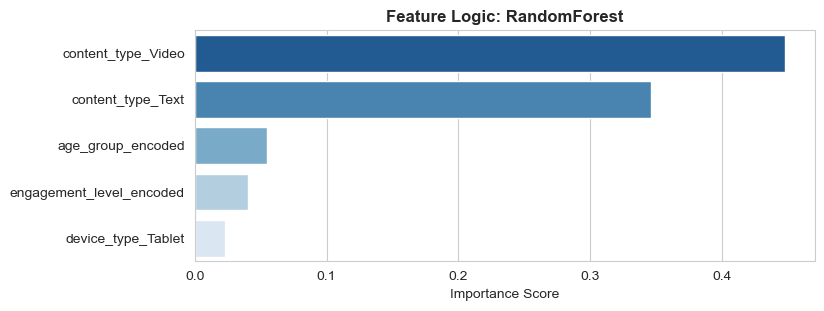

C:\Users\gonal\AppData\Local\Temp\ipykernel_12100\677952582.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map[name])


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

Training XGBoost...
✅ XGBoost Top 5 Features:
                    Feature  Importance
         content_type_Video    0.750368
          content_type_Text    0.225989
          age_group_encoded    0.003593
             location_India    0.003416
ad_target_audience_Students    0.003274


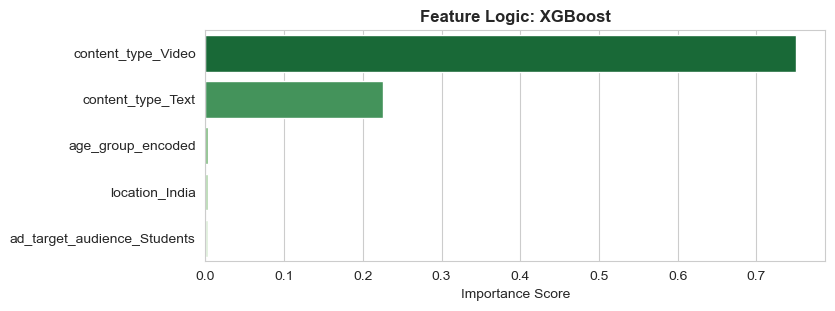

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬

Training LightGBM...
✅ LightGBM Top 5 Features:
                 Feature  Importance
       age_group_encoded         884
engagement_level_encoded         574
      device_type_Tablet         225
       content_type_Text         199
      content_type_Video         173


C:\Users\gonal\AppData\Local\Temp\ipykernel_12100\677952582.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map[name])


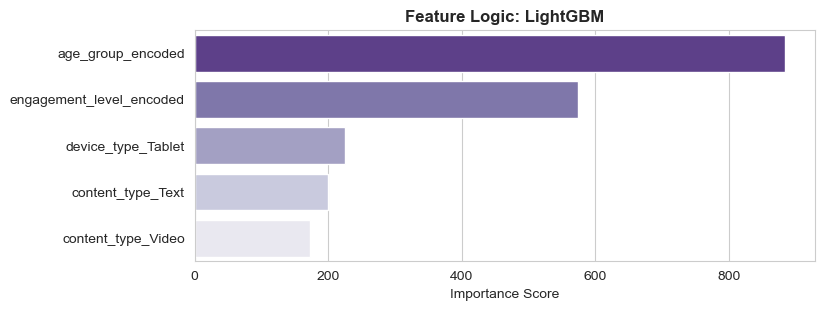

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


In [6]:
# 2. Loop through each model to Train & Visualize
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # A. Train the model fresh
    model.fit(X_train, y_train)
    
    # B. Extract Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Create a clean DataFrame
        feat_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(5) # Keep top 5
        
        # C. Print the Numbers (The "Evidence")
        print(f"✅ {name} Top 5 Features:")
        print(feat_df.to_string(index=False))
        
        # D. Plot the Graph (The "Visual")
        plt.figure(figsize=(8, 3))
        # Color coding: RF=Blue, XGB=Green, LGBM=Purple for distinctness
        color_map = {'RandomForest': 'Blues_r', 'XGBoost': 'Greens_r', 'LightGBM': 'Purples_r'}
        
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map[name])
        plt.title(f'Feature Logic: {name}', fontsize=12, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('')
        plt.show()
        print("▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬")
    else:
        print(f"⚠️ Model {name} does not support feature importance.")

# Saving the model

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

if 'best_opt_model' in locals():
    filename = f"Exp4_User_{best_model_name}_Opt_R2-{opt_r2:.3f}_{timestamp}.joblib"
    save_dir = "../src/models"
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_path = os.path.join(save_dir, filename)
    joblib.dump(best_opt_model, save_path)
    print(f"✅ Saved Exp4 Model: {save_path}")
else:
    print("❌ optimization didn't run. Model not saved.")

✅ Saved Exp4 Model: ../src/models\Exp4_User_LightGBM_Opt_R2-0.773_20260116_0012.joblib
